In [1]:
import nomic
import json
api_key_path = "/home/ubuntu/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)

#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm
from graspologic.embed import ClassicalMDS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz

data_dir = '../../data/data/'
vote_str = '118-2024_h142'

dataset = pd.read_csv(f'{data_dir}{vote_str}.csv')
dataset = dataset.dropna(axis=0)

average_embd = {
    'global': np.array([eval(d) for d in dataset['average-embd-global'].values]),
     'issue-specific': np.array([eval(d) for d in dataset['average-embd-issue-specific'].values])
}


average_embd = {k: v / np.linalg.norm(v, axis=1, keepdims=True) for k,v in average_embd.items()
}

vote = np.array([v for v in dataset['vote'].values])
vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'black'
}

party = np.array([p for p in dataset['matched-party'].values])
party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
}

voted_inds = []
y_vote = []
for i, v in enumerate(vote):
    if v.lower() == 'nay':
        y_vote.append(0)
    elif v.lower() == 'yea':
        y_vote.append(1)
    else:
        continue
    voted_inds.append(i)
    
voted_inds = np.array(voted_inds)

dataset.head()

/home/ubuntu/venvs/pnma/lib/python3.8/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)
/home/ubuntu/venvs/pnma/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,Unnamed: 0,person,state,district,vote,name,party,matched-name,twitter-handle,matched-party,matched-state,average-embd-global,average-embd-issue-specific
0,0,400004,AL,4,Yea,Rep. Robert Aderholt [R],Republican,"Aderholt, Robert",robert_aderholt,R,AL,"[0.017503820146833146, 0.03896857670375279, -0...","[0.006040811538696289, 0.042439937591552734, -..."
1,1,400030,GA,2,Not Voting,Rep. Sanford Bishop [D],Democrat,"Bishop Jr., Sanford",sanfordbishop,D,GA,"[0.018433302640914917, 0.049648284912109375, -...","[0.017269134521484375, 0.0095062255859375, -0...."
3,3,400052,TX,26,Yea,Rep. Michael Burgess [R],Republican,"Burgess, Michael",michaelcburgess,R,TX,"[0.021851594874400967, 0.05065598708904342, -0...","[0.02545155649599822, 0.08420595915421196, -0...."
4,4,400057,CA,41,Yea,Rep. Ken Calvert [R],Republican,"Calvert, Ken",kencalvert,R,CA,"[0.018314135260879993, 0.05678512156009674, -0...","[0.020268772777758147, 0.06673792788856908, -0..."
5,5,400068,TX,31,Yea,Rep. John R. Carter [R],Republican,"Carter, John",judgecarter,R,TX,"[0.02061185469994178, 0.0426945319542518, -0.1...","[0.030901227678571428, 0.078216552734375, -0.1..."


Text(0.5, 1.0, 'CMDS[issue-specific] // by vote')

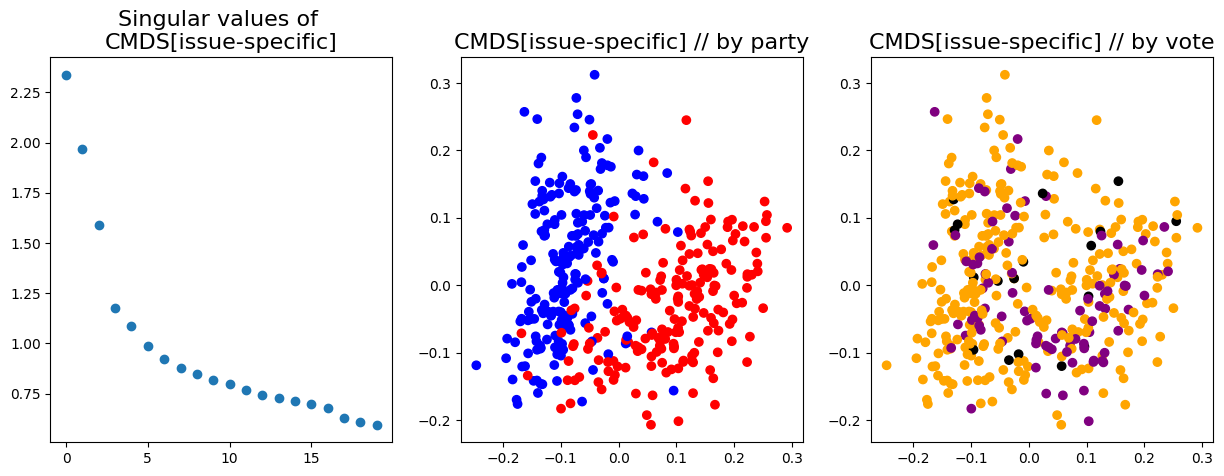

In [2]:
key = 'issue-specific'
cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd[key])
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd[key])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title(f'Singular values of \nCMDS[{key}]', fontsize=16)
ax[1].set_title(f'CMDS[{key}] // by party', fontsize=16)
ax[2].set_title(f'CMDS[{key}] // by vote', fontsize=16)

Text(0.5, 1.02, 'Efficacy of representation+LogReg \n for 118-2024_h142')

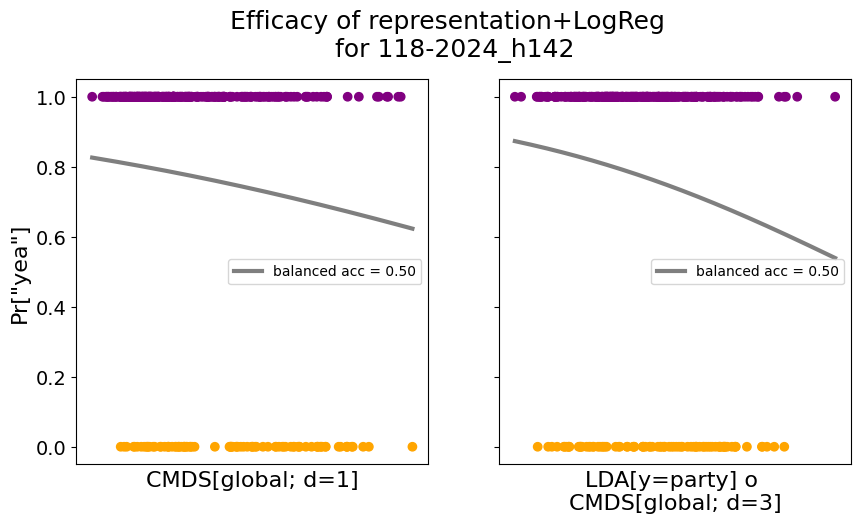

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

x = cmds_embds[voted_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y_vote)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y_vote])
ax[0].scatter(x, y_vote, c=color_list)

# Plot the logistic regression curve
er = bas(y_vote, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].set_xlabel(f'CMDS[{key}; d=1]', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[voted_inds], party[voted_inds])
x = lda.transform(cmds_embds[voted_inds])

party_model = LogisticRegression()
party_model.fit(x, y_vote)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y_vote, c=color_list)

er = bas(y_vote, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].set_xlabel(f'LDA[y=party] o \nCMDS[{key}; d={cmds_embds.shape[1]}]', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)
    ax_.legend(loc='center right')

fig.suptitle(f'Efficacy of representation+LogReg \n for {vote_str}', fontsize=18, y=1.02)

Text(0.5, 1.0, 'CMDS[global] // by vote')

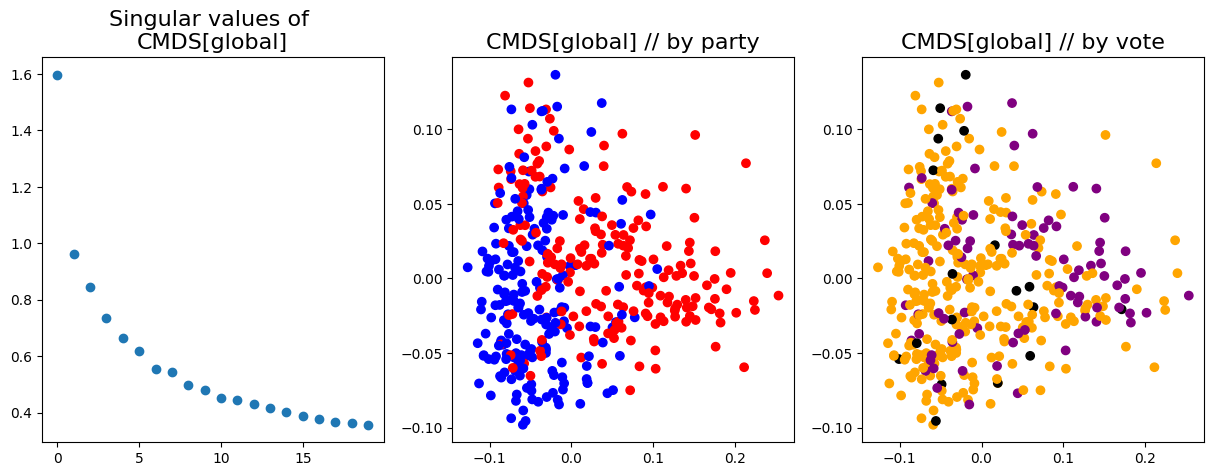

In [4]:
key = 'global'
cmds = ClassicalMDS(n_components=20)
_ = cmds.fit_transform(average_embd[key])
svs = cmds.singular_values_

cmds = ClassicalMDS()
cmds_embds = cmds.fit_transform(average_embd[key])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(range(len(svs)), svs)
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[party_colors[p.lower()] for p in party])
ax[2].scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[vote_colors[v.lower()] for v in vote])

ax[0].set_title(f'Singular values of \nCMDS[{key}]', fontsize=16)
ax[1].set_title(f'CMDS[{key}] // by party', fontsize=16)
ax[2].set_title(f'CMDS[{key}] // by vote', fontsize=16)

Text(0.5, 1.02, 'Efficacy of representation+LogReg \n for 118-2024_h142')

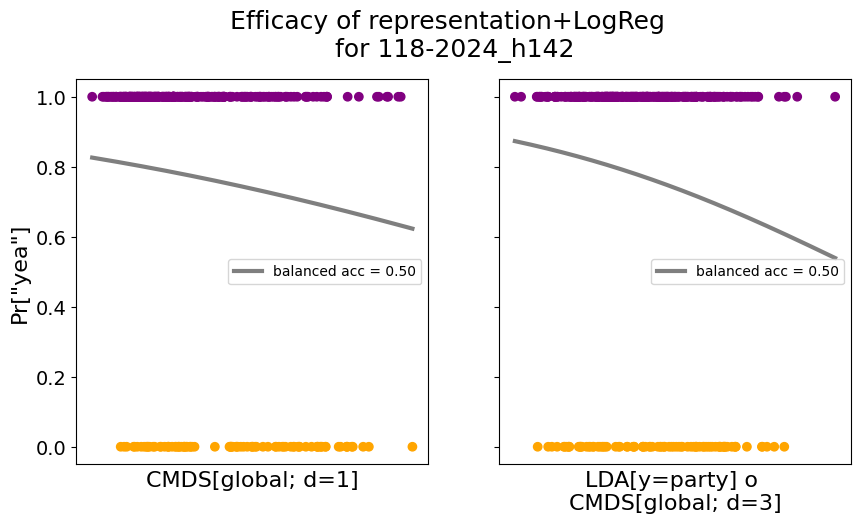

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].set_ylabel('Pr["yea"]', fontsize=16)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])

x = cmds_embds[voted_inds,:1]

vote_model = LogisticRegression()
vote_model.fit(x, y_vote)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = vote_model.predict_proba(xr)[:, 1]

color_list = np.array(['orange' if v == 0 else 'purple' for v in y_vote])
ax[0].scatter(x, y_vote, c=color_list)

# Plot the logistic regression curve
er = bas(y_vote, vote_model.predict(x))
ax[0].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[0].set_xlabel(f'CMDS[{key}; d=1]', fontsize=16)

lda = LinearDiscriminantAnalysis()
lda.fit(cmds_embds[voted_inds], party[voted_inds])
x = lda.transform(cmds_embds[voted_inds])

party_model = LogisticRegression()
party_model.fit(x, y_vote)

xr = np.linspace(min(x), max(x), 300).reshape(-1, 1)
yr = party_model.predict_proba(xr)[:, 1]

ax[1].scatter(x, y_vote, c=color_list)

er = bas(y_vote, party_model.predict(x))
ax[1].plot(xr, yr, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

ax[1].set_xlabel(f'LDA[y=party] o \nCMDS[{key}; d={cmds_embds.shape[1]}]', fontsize=16)

for ax_ in ax:
    ax_.set_xticks([])
    ax_.tick_params(labelsize=14)
    ax_.legend(loc='center right')

fig.suptitle(f'Efficacy of representation+LogReg \n for {vote_str}', fontsize=18, y=1.02)